# Imports

In [1]:
from collections import defaultdict

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Function definitions

In [2]:
#new

def split_ts_data(data, val_start, test_start):
    year_min = min(data['Year'])
    year_max = max(data['Year'])
    year_range = year_max-year_min
    
    assert (val_start >= year_min) & (test_start >= year_min) & (val_start <= year_max) & (test_start <= year_max), "Parameter out of bounds"
    assert (val_start > year_min) & (test_start > year_min), "Training set is empty."
    assert val_start < test_start, "Validation set is empty."
    assert year_range > 0, "Data contains less than 2 years."
    
    
    train_data = data[(data['Year']<val_start) & (data['Year']<test_start)]
    val_data = data[(data['Year']>=val_start) & (data['Year']<test_start)]
    test_data = data[data['Year']>=test_start]
    
    return train_data, val_data, test_data

In [3]:
def make_dataset(df, input_width, label_width, shift):
    def create_window(tensor):
        #input -> length of time series used for training
        #shift -> how far off prediction is from last input
        #label -> points to predict
        total_window_size = input_width + shift
        label_start = total_window_size - label_width

        input_bounds = slice(0, input_width)
        label_bounds = slice(label_start, None)

        inputs = tensor[:,input_bounds,:]
        labels = tensor[:,label_bounds,:]

        inputs.set_shape([None, input_width, None])
        labels.set_shape([None, label_width, None])

        return inputs, labels
    
    total_window_size = input_width + shift
    
    arr = np.array(df, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=arr,
      targets=None,
      sequence_length=total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
    
    ds = ds.map(create_window)
    
    return ds

In [4]:
def compile_and_fit(model, epochs, input_optimizer='adam', input_loss='mse'):
    model.compile(optimizer=input_optimizer, loss=input_loss)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    
    return history

In [5]:
def col_dict(np_df):
    return_dict = {col:index for index, col in enumerate(np_df.columns)}
    
    return return_dict

In [6]:
def plot(df, ds, input_width, label_width, shift, model=None, plot_col='10101 m0.4', max_subplots=3):
    #ensure that df and ds match e.g. train_df must be accompanied by train_ds
    col_indices = col_dict(df)
    
    total_window_size = label_width + shift
    input_slice = slice(0,input_width)
    input_indices = np.arange(total_window_size)[input_slice]
    label_start = total_window_size - label_width
    labels_slice = slice(label_start, None)
    label_indices = np.arange(total_window_size)[labels_slice]
    
    inputs = next(iter(ds))[0]
    labels = next(iter(ds))[1]
    plt.figure(figsize=(12, 8))
    plot_col_index = col_indices[plot_col] 
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(plot_col)
        plt.plot(input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
        
        plt.scatter(label_indices, labels[n, :, plot_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
          predictions = model(inputs)
          plt.scatter(label_indices, predictions[n, :, plot_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            
        if n == 0:
          plt.legend()
        
    plt.xlabel('Year')

# Main code

## Edit parameters here, but do not rename variables

## Read, preprocess data

In [7]:
raw_data = pd.read_csv('newSA3.csv')



#Parameters
validation_start = 2002
test_start = 2006
#



train_df, val_df, test_df = split_ts_data(raw_data, validation_start, test_start)

train_df = train_df[train_df.columns.difference(["Unnamed: 0","Year"])]
val_df = val_df[val_df.columns.difference(["Unnamed: 0","Year"])]
test_df = test_df[test_df.columns.difference(["Unnamed: 0","Year"])]

In [8]:
raw_data.head()

,Unnamed: 0,Year,10101 m0.4,10102 m0.4,10103 m0.4,10104 m0.4,10201 m0.4,10202 m0.4,10301 m0.4,10302 m0.4,...,70203 f85.,70204 f85.,70205 f85.,80101 f85.,80103 f85.,80105 f85.,80106 f85.,80107 f85.,80108 f85.,80109 f85.
0,1,1991,2603,1593,741,1985,5373,4332,1530,2621,...,4,2,5,145,2,178,196,41,91,116
1,2,1992,2605,1625,740,1962,5504,4503,1522,2615,...,6,5,6,164,6,180,201,49,93,134
2,3,1993,2585,1638,736,1920,5577,4620,1496,2580,...,8,6,7,187,9,191,221,58,103,154
3,4,1994,2557,1643,728,1873,5620,4716,1474,2540,...,12,9,8,199,11,198,230,65,107,171
4,5,1995,2508,1631,714,1803,5632,4772,1442,2470,...,16,13,10,221,15,201,244,69,114,190


In [9]:
train_df

,10101 f0.4,10101 f10.14,10101 f15.19,10101 f20.24,10101 f25.29,10101 f30.34,10101 f35.39,10101 f40.44,10101 f45.49,10101 f5.9,...,80109 m45.49,80109 m5.9,80109 m50.54,80109 m55.59,80109 m60.64,80109 m65.69,80109 m70.74,80109 m75.79,80109 m80.84,80109 m85.
0,2400,2347,2277,1820,2152,2315,2185,2146,1859,2495,...,1219,1002,1226,920,784,606,328,180,98,50
1,2392,2344,2194,1830,2067,2339,2204,2139,1954,2480,...,1257,1009,1209,931,794,617,376,200,104,55
2,2382,2354,2126,1813,1977,2329,2225,2139,2037,2451,...,1285,993,1154,963,792,634,413,209,105,59
3,2357,2351,2084,1777,1913,2316,2232,2158,2079,2418,...,1284,988,1123,998,778,649,459,212,112,65
4,2318,2357,2055,1734,1869,2272,2256,2165,2111,2403,...,1277,998,1105,1020,819,648,486,247,116,69
5,2280,2360,2060,1656,1869,2218,2290,2186,2150,2400,...,1244,1015,1112,1051,833,672,513,277,124,74
6,2242,2327,2054,1555,1905,2104,2340,2208,2153,2393,...,1188,985,1117,1086,835,676,527,316,123,79
7,2171,2338,2051,1480,1912,2054,2403,2171,2153,2400,...,1157,975,1127,1083,847,690,572,358,142,88
8,2132,2348,2039,1450,1892,2005,2395,2217,2195,2400,...,1149,975,1123,1051,851,694,598,389,163,95
9,2107,2335,2029,1452,1848,1991,2363,2251,2201,2393,...,1122,967,1163,997,892,717,577,439,190,103


In [10]:
val_df

,10101 f0.4,10101 f10.14,10101 f15.19,10101 f20.24,10101 f25.29,10101 f30.34,10101 f35.39,10101 f40.44,10101 f45.49,10101 f5.9,...,80109 m45.49,80109 m5.9,80109 m50.54,80109 m55.59,80109 m60.64,80109 m65.69,80109 m70.74,80109 m75.79,80109 m80.84,80109 m85.
11,2068,2272,2072,1450,1682,2080,2189,2323,2239,2319,...,1114,984,1132,986,960,692,590,452,253,128
12,2033,2317,2078,1466,1622,2116,2172,2394,2217,2299,...,1115,990,1078,1003,920,713,601,454,285,127
13,2035,2372,2058,1481,1585,2089,2152,2419,2220,2256,...,1136,978,1065,993,887,728,584,476,298,129
14,2038,2406,2052,1520,1571,2025,2171,2403,2240,2216,...,1192,979,1027,1030,828,754,599,471,313,156


In [11]:
test_df

,10101 f0.4,10101 f10.14,10101 f15.19,10101 f20.24,10101 f25.29,10101 f30.34,10101 f35.39,10101 f40.44,10101 f45.49,10101 f5.9,...,80109 m45.49,80109 m5.9,80109 m50.54,80109 m55.59,80109 m60.64,80109 m65.69,80109 m70.74,80109 m75.79,80109 m80.84,80109 m85.
15,2005,2428,2034,1570,1566,1936,2246,2337,2292,2232,...,1248,992,1030,1031,795,771,589,499,325,195
16,2011,2375,2112,1542,1583,1875,2288,2247,2352,2210,...,1279,962,1042,988,798,818,599,480,356,214
17,2044,2343,2145,1594,1640,1840,2314,2246,2418,2210,...,1283,954,1068,971,826,783,627,484,361,234
18,2109,2330,2182,1670,1662,1857,2312,2256,2463,2213,...,1296,968,1082,975,852,768,643,481,363,250
19,2170,2336,2230,1722,1691,1883,2274,2328,2474,2217,...,1262,983,1129,962,893,741,674,492,360,264
20,2225,2381,2178,1698,1681,1864,2252,2426,2430,2217,...,1201,974,1194,927,867,756,716,505,414,282


## Create tf datasets

In [12]:
#Parameters
input_width = 2 #data used in prediction
label_width = 1 #points to predict
shift = 1 #how many years away is the last point to predict
#



train_ds = make_dataset(train_df, input_width, label_width, shift)
val_ds = make_dataset(val_df, input_width, label_width, shift)
test_ds = make_dataset(test_df, input_width, label_width, shift)

num_cols = next(iter(train_ds))[0].shape[2]

## Create and fit model

In [21]:
#Parameters
num_epochs = 10

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dense(label_width * num_cols))
model.add(tf.keras.layers.Reshape([label_width,num_cols]))
#



compile_and_fit(model, num_epochs, input_optimizer='adam', input_loss='mse')

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 4179144.5000 - val_loss: 4692178.0000
Epoch 2/10
1/1 [==============================] - 0s 85ms/step - loss: 4133606.2500 - val_loss: 4662759.0000
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 4106349.0000 - val_loss: 4617698.0000
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 4075115.0000 - val_loss: 4526393.0000
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 3996172.5000 - val_loss: 4405156.0000
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 3890982.7500 - val_loss: 4277542.0000
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 3779799.0000 - val_loss: 4173783.5000
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 3683877.0000 - val_loss: 4000429.5000
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 3538824.0000 - val_loss: 3830717.5000
Epoch 10/10
1/1 [====

In [22]:
train_inputs = next(iter(train_ds))[0]
train_labels = next(iter(train_ds))[1]
train_predictions = model(train_inputs)

In [23]:
train_labels

<tf.Tensor: shape=(9, 1, 11700), dtype=float32, numpy=
array([[[2382., 2354., 2126., ...,  209.,  105.,   59.]],

       [[2357., 2351., 2084., ...,  212.,  112.,   65.]],

       [[2318., 2357., 2055., ...,  247.,  116.,   69.]],

       ...,

       [[2132., 2348., 2039., ...,  389.,  163.,   95.]],

       [[2107., 2335., 2029., ...,  439.,  190.,  103.]],

       [[2077., 2259., 2051., ...,  457.,  221.,  119.]]], dtype=float32)>

In [24]:
train_predictions

<tf.Tensor: shape=(9, 1, 11700), dtype=float32, numpy=
array([[[1817.3302 , 1086.5784 , -784.5439 , ...,  323.66547,
          246.98868,  392.82645]],

       [[1832.4203 , 1095.6006 , -791.05835, ...,  326.3529 ,
          249.03947,  396.0883 ]],

       [[1849.208  , 1105.638  , -798.30585, ...,  329.34274,
          251.32101,  399.7171 ]],

       ...,

       [[1939.6744 , 1159.7274 , -837.36096, ...,  345.45435,
          263.6158 ,  419.27216]],

       [[1964.3333 , 1174.4708 , -848.0064 , ...,  349.84595,
          266.96704,  424.60236]],

       [[1990.9243 , 1190.3695 , -859.486  , ...,  354.5817 ,
          270.5809 ,  430.35022]]], dtype=float32)>

In [25]:
test_inputs = next(iter(test_ds))[0]
test_labels = next(iter(test_ds))[1]
test_predictions = model(test_inputs)



In [26]:
test_labels

<tf.Tensor: shape=(4, 1, 11700), dtype=float32, numpy=
array([[[2044., 2343., 2145., ...,  484.,  361.,  234.]],

       [[2109., 2330., 2182., ...,  481.,  363.,  250.]],

       [[2170., 2336., 2230., ...,  492.,  360.,  264.]],

       [[2225., 2381., 2178., ...,  505.,  414.,  282.]]], dtype=float32)>

In [27]:
test_predictions

<tf.Tensor: shape=(4, 1, 11700), dtype=float32, numpy=
array([[[2174.5435 , 1304.8237 , -921.7833 , ...,  370.85275,
          298.16245,  487.31314]],

       [[2217.387  , 1330.7904 , -939.0044 , ...,  377.24875,
          304.1824 ,  497.8716 ]],

       [[2263.7412 , 1359.0331 , -957.0978 , ...,  383.64737,
          310.77902,  509.84338]],

       [[2298.0193 , 1379.972  , -970.28107, ...,  388.18878,
          315.68756,  518.89636]]], dtype=float32)>

In [29]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 40ms/step - loss: 4311915.0000


4311915.0

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

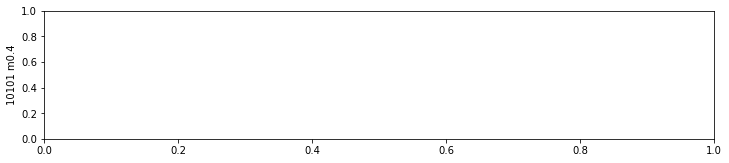

In [28]:
plot(train_df, train_ds, input_width=1, label_width=1, shift=1, model=model, plot_col='10101 m0.4', max_subplots=3)